# classifier

**import**

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

**functions**

In [8]:
import tensorflow.keras.preprocessing.image as tfimage

def load_datasets(path):
  clean = []
  types = []
  label = []

  # loop over every folder
  i = -1
  k = 0
  for folder in os.listdir(path):
    i += 1
    label.append(folder)
    print(i, ": ", folder)
    for file in os.listdir(path + '/' + folder):
        # image = tfimage.load_img(path + '/' + folder + '/' + file, target_size=(256,256))
        # image = tfimage.img_to_array(image).astype('float32') / 255
        img = tfimage.load_img(path + '/' + folder + '/' + file)
        img = cv2.imread(os.path.join(path,folder,file),cv2.IMREAD_GRAYSCALE) # Convert to Image to Grayscale bc contour
        img=~img # Invert the bits of image 255 -> 0 / test the dataset
        if img is not None:
          ret,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY) # THRESH_BINARY: Set bits > 127 to 1(white background) and <= 127 to 0(black) 
          ctrs, ret = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # determine object boundary, remove background
          cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
          w=int(28)
          h=int(28)
          # maximum area of the rectangle
          maxi=0
          for c in cnt: # traverse in all the rectangles we have
            x,y,w,h=cv2.boundingRect(c)
            maxi=max(w*h,maxi)
            if maxi==w*h:
              x_max=x
              y_max=y
              w_max=w
              h_max=h
          im_crop= thresh[y_max:y_max+h_max+10, x_max:x_max+w_max+10] # add 10 extra margin to avoid error
          im_resize = cv2.resize(im_crop,(28,28))
          im_resize =  tfimage.img_to_array(im_resize).astype('float32') / 255
          #im_resize=np.reshape(im_resize,(784,1)) #resize to (28,28)
          clean.append(im_resize) # flat the matrix
          types.append(i)

  types = tf.one_hot(types, depth=i+1)
  types = np.array(types)
  clean = np.array(clean)

  print("image shape: ", clean.shape)
  print("label shape: ", types.shape)
  
  return types, clean, label

In [3]:
from tensorflow.keras import layers, Model

def build_model(class_num):
  img_input = layers.Input(shape=(28, 28, 1))

  x = layers.Conv2D(30, 5, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)

  x = layers.Conv2D(15, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # x = layers.Conv2D(8, 1, activation='relu')(x)
  # x = layers.MaxPooling2D(2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(50, activation='relu')(x)
  output = layers.Dense(class_num, activation='softmax')(x)

  model = Model(img_input, output)

  return model

In [4]:
from sklearn.model_selection import KFold

def k_fold_cv(class_num, inputs, targets, num_folds):
    callback = tf.keras.callbacks.EarlyStopping(
        monitor = 'loss',
        patience = 3,
        restore_best_weights = True)
    acc_per_fold = []
    loss_per_fold = []
    kfold = KFold(n_splits=num_folds, shuffle=True)
    # start k fold
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        # compile the model
        model = build_model(class_num)
        model.compile(
            optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
        # print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        # fit model
        history = model.fit(
            x = inputs[train], y = targets[train],
            batch_size = 20,
            epochs = 20,
            callbacks = [callback])
        # print result
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1

    return acc_per_fold, loss_per_fold

# main

**create model**

In [5]:
# load data
path = 'C:\\Users\\USER\\Desktop\\Handwritten-Equation-Recognition---CNN-master\\dataset'
types, clean, label = load_datasets(path)

0 :  +
1 :  -
2 :  0
3 :  1
4 :  2
5 :  3
6 :  4
7 :  5
8 :  6
9 :  7
10 :  8
11 :  9
12 :  x
image shape:  (156617, 28, 28, 1)
label shape:  (156617, 13)


In [9]:
# build model
class_num = 13
classifier = build_model(class_num)
print(classifier.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)              

**validate model**

In [10]:
num_folds = 5
acc_per_fold, loss_per_fold = k_fold_cv(class_num, clean, types, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
6265/6265 [==============================] - 62s 10ms/step - loss: 0.1566 - accuracy: 0.9561
Epoch 2/20
6265/6265 [==============================] - 62s 10ms/step - loss: 0.0539 - accuracy: 0.9852
Epoch 3/20
6265/6265 [==============================] - 77s 12ms/step - loss: 0.0377 - accuracy: 0.9896
Epoch 4/20
6265/6265 [==============================] - 63s 10ms/step - loss: 0.0285 - accuracy: 0.9921
Epoch 5/20
6265/6265 [==============================] - 61s 10ms/step - loss: 0.0246 - accuracy: 0.9932
Epoch 6/20
6265/6265 [==============================] - 60s 10ms/step - loss: 0.0219 - accuracy: 0.9937
Epoch 7/20
6265/6265 [==============================] - 64s 10ms/step - loss: 0.0191 - accuracy: 0.9945
Epoch 8/20
6265/6265 [==============================] - 66s 11ms/step - loss: 0.0168 - accuracy: 0.9952
Epoch 9/20
6265/6265 [==============================] - 65s 10ms/step -

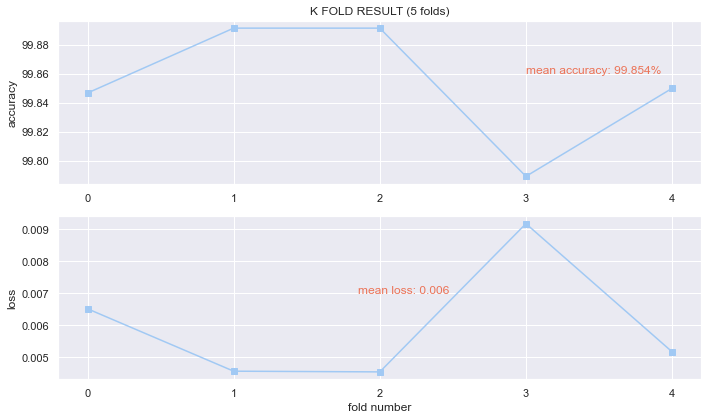

In [32]:
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")

fig, axs = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)

axs[0].set_title('K FOLD RESULT (5 folds)')
axs[0].plot(acc_per_fold, '-s')
axs[0].set_ylabel('accuracy')
axs[0].xaxis.set_ticks(range(0, 5))
axs[0].text(3, 99.86, f'mean accuracy: {round(np.mean(acc_per_fold), 3)}%', color='#ec7357')

axs[1].plot(loss_per_fold, '-s')
axs[1].set_ylabel('loss')
axs[1].xaxis.set_ticks(range(0, 5))
axs[1].set_xlabel('fold number')
axs[1].text(1.85, 0.007, f'mean loss: {round(np.mean(loss_per_fold), 3)}', color='#ec7357')

plt.savefig('k_fold')
plt.show()